# TSP Algorithm Analysis

Comprehensive comparison of TSP algorithms with both best and current cost tracking.

In [1]:
from tsp.io import parse_tsplib_tsp
from algorithm.nearest_neighbor import NearestNeighbor
from algorithm.simulated_annealing import SimulatedAnnealing
from algorithm.random_solver import RandomSolver
from pathlib import Path
import time
import matplotlib.pyplot as plt

# Configuration
MAX_ITERATIONS = 1_000  # Number of iterations for iteration-based benchmark
MAX_SECONDS = 1.0      # Number of seconds for time-based benchmark
RANDOM_SEED = 42       # Random seed for reproducible results
COOLING_RATE = 0.995  # Cooling rate for Simulated Annealing

In [2]:
# Annealing schedule

def exponential_cooling(alpha: float) -> callable:
    """Return a cooling function with fixed decay rate alpha: T_k+1 = alpha * T_k."""
    def cool(t: float) -> float:
        return t * alpha
    return cool

In [3]:
# Load instance
instance = parse_tsplib_tsp(Path("dataset/berlin52.tsp"))
print(f"Loaded {instance.name} with {len(instance.cities)} cities")

# Check for optimal tour file
opt_tour_path = Path(f"dataset/{instance.name}.opt.tour")
optimal_cost = None
if opt_tour_path.exists():
    print(f"Found optimal tour file: {opt_tour_path}")
    # Parse optimal tour (simple format: just city indices)
    with open(opt_tour_path, "r") as f:
        lines = f.readlines()
    
    # Find TOUR_SECTION and read tour
    in_tour = False
    tour = []
    for line in lines:
        line = line.strip()
        if line.upper().startswith("TOUR_SECTION"):
            in_tour = True
            continue
        if line.upper().startswith("EOF") or line == "-1":
            break
        if in_tour and line:
            try:
                # Convert 1-based TSPLIB ids to 0-based indices
                city_id = int(line) - 1
                tour.append(city_id)
            except ValueError:
                continue
    
    if tour:
        optimal_cost = instance.route_cost(tour)
        print(f"Optimal cost: {optimal_cost:.2f}")
    else:
        print("Could not parse optimal tour")
else:
    print("No optimal tour file found")

Loaded berlin52 with 52 cities
Found optimal tour file: dataset\berlin52.opt.tour
Optimal cost: 7544.37


In [4]:
def run_algorithm_with_timing(instance, solver, initial_route, max_seconds=MAX_SECONDS):
    """Run algorithm for fixed time and collect cost at each step."""
    solver.initialize(initial_route)
    
    iterations = []
    best_costs = []
    current_costs = []
    times = []
    
    start_time = time.perf_counter()
    
    while time.perf_counter() - start_time < max_seconds:
        report = solver.step()
        current_time = time.perf_counter() - start_time
        
        iterations.append(report.iteration)
        best_costs.append(report.best_cost)
        current_costs.append(report.current_cost)
        times.append(current_time)
    
    return iterations, best_costs, current_costs, times


def run_algorithm_with_iterations(instance, solver, initial_route, max_iterations=MAX_ITERATIONS):
    """Run algorithm for fixed number of iterations and collect cost at each step."""
    if hasattr(solver, "initialize"):
        solver.initialize(initial_route)
    else:
        raise ValueError("Solver must have an 'initialize' method")
    
    iterations = []
    best_costs = []
    current_costs = []
    times = []
    
    start_time = time.perf_counter()
    
    for i in range(max_iterations):
        report = solver.step()
        current_time = time.perf_counter() - start_time
        
        iterations.append(report.iteration)
        best_costs.append(report.best_cost)
        current_costs.append(report.current_cost)
        times.append(current_time)
    
    return iterations, best_costs, current_costs, times


In [5]:
# Seed routes: identity and Nearest Neighbor
seed_identity = list(range(len(instance.cities)))

# Build Nearest Neighbor seed route fully
_nn_builder = NearestNeighbor(instance)
_nn_builder.initialize(seed_identity)
for _ in range(len(instance.cities) - 1):
    _ = _nn_builder.step()
seed_nn = _nn_builder.get_route()

# Create a schedule that ends at Tend_target after MAX_ITERATIONS
T0 = 100
exp_schedule = exponential_cooling(COOLING_RATE)

# Algorithms with their specific seeds
algorithms = {
    "BASELINE - Random Solver": (RandomSolver(instance, seed=RANDOM_SEED), None),
    "Nearest Neighbor": (NearestNeighbor(instance), seed_identity),
    "SA (Exp-for, NN-seed)": (SimulatedAnnealing(instance, T0, exp_schedule, seed=RANDOM_SEED), seed_nn),
    "SA (Exp-for, random)": (SimulatedAnnealing(instance, T0, exp_schedule, seed=RANDOM_SEED), None),
}

time_results = {}
for name, (solver, init_route) in algorithms.items():
    print(f"Running {name} for {MAX_SECONDS} second(s)...")
    iterations, best_costs, current_costs, times = run_algorithm_with_timing(instance, solver, init_route, MAX_SECONDS)
    time_results[name] = {
        'iterations': iterations,
        'best_costs': best_costs,
        'current_costs': current_costs,
        'times': times,
        'final_cost': best_costs[-1] if best_costs else float('inf'),
        'total_iterations': len(iterations)
    }
    print(f"  Final cost: {time_results[name]['final_cost']:.2f}")
    print(f"  Iterations: {time_results[name]['total_iterations']}")


Running BASELINE - Random Solver for 1.0 second(s)...
  Final cost: 22205.62
  Iterations: 2471
Running Nearest Neighbor for 1.0 second(s)...
  Final cost: 8980.92
  Iterations: 4682
Running SA (Exp-for, NN-seed) for 1.0 second(s)...
  Final cost: 7852.74
  Iterations: 3091
Running SA (Exp-for, random) for 1.0 second(s)...
  Final cost: 8871.36
  Iterations: 5210


In [6]:
# Run algorithms for iteration-based benchmark
iteration_results = {}
for name, (solver, init_route) in algorithms.items():
    print(f"Running {name} for {MAX_ITERATIONS} iterations...")
    iterations, best_costs, current_costs, times = run_algorithm_with_iterations(instance, solver, init_route, MAX_ITERATIONS)
    iteration_results[name] = {
        'iterations': iterations,
        'best_costs': best_costs,
        'current_costs': current_costs,
        'times': times,
        'final_cost': best_costs[-1] if best_costs else float('inf'),
        'total_time': times[-1] if times else 0
    }
    print(f"  Final cost: {iteration_results[name]['final_cost']:.2f}")
    print(f"  Total time: {iteration_results[name]['total_time']:.3f} seconds")


Running BASELINE - Random Solver for 1000 iterations...
  Final cost: 22205.62
  Total time: 0.241 seconds
Running Nearest Neighbor for 1000 iterations...
  Final cost: 8980.92
  Total time: 0.193 seconds
Running SA (Exp-for, NN-seed) for 1000 iterations...
  Final cost: 8501.11
  Total time: 0.196 seconds
Running SA (Exp-for, random) for 1000 iterations...
  Final cost: 10510.11
  Total time: 0.181 seconds


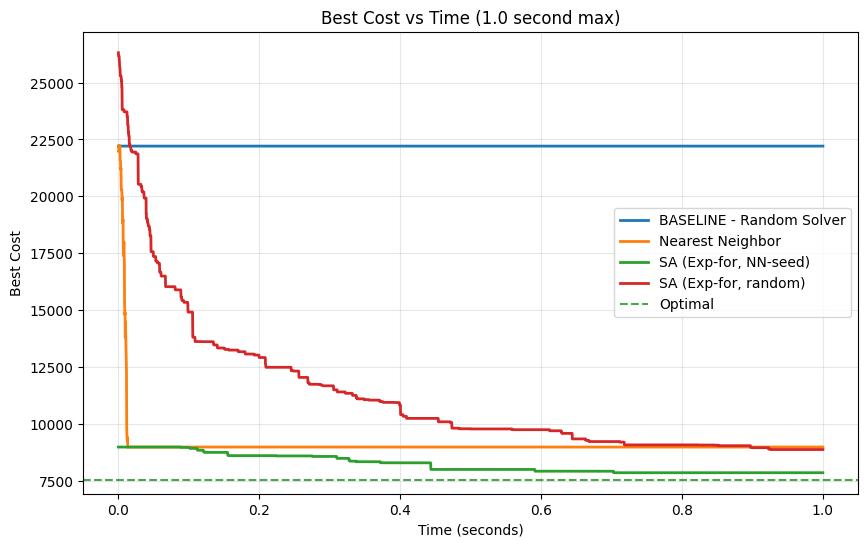

In [7]:
# Plot: Best Cost vs Time
plt.figure(figsize=(10, 6))
for name, data in time_results.items():
    plt.plot(data['times'], data['best_costs'], label=name, linewidth=2)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Time (seconds)')
plt.ylabel('Best Cost')
plt.title(f'Best Cost vs Time ({MAX_SECONDS} second max)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


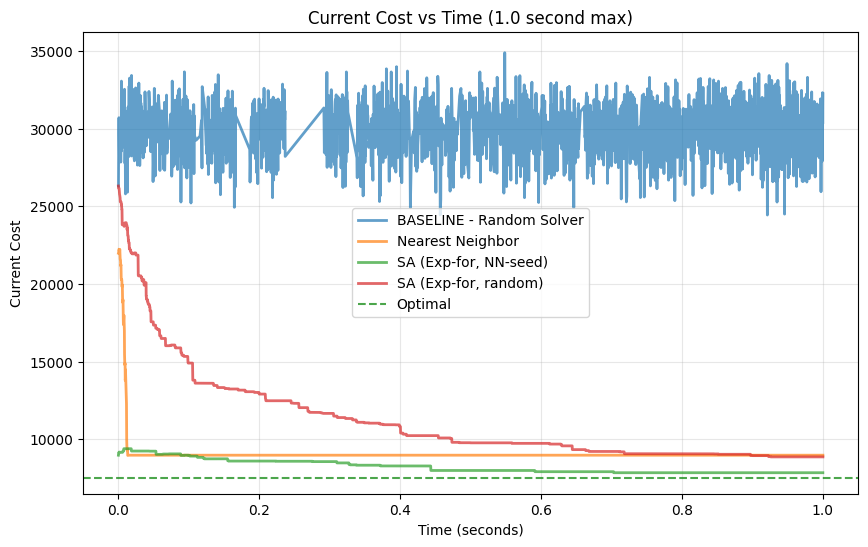

In [8]:
# Plot: Current Cost vs Time
plt.figure(figsize=(10, 6))
for name, data in time_results.items():
    plt.plot(data['times'], data['current_costs'], label=name, linewidth=2, alpha=0.7)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Time (seconds)')
plt.ylabel('Current Cost')
plt.title(f'Current Cost vs Time ({MAX_SECONDS} second max)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


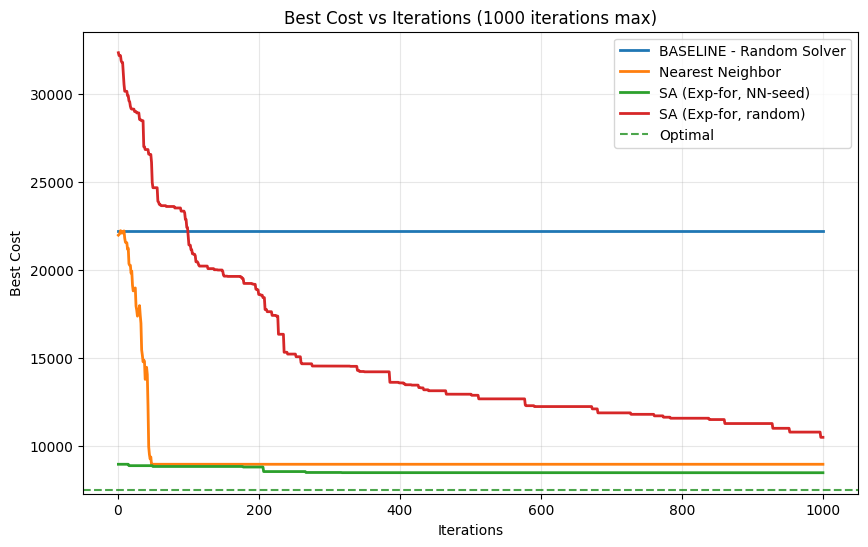

In [9]:
# Plot: Best Cost vs Iterations
plt.figure(figsize=(10, 6))
for name, data in iteration_results.items():
    plt.plot(data['iterations'], data['best_costs'], label=name, linewidth=2)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title(f'Best Cost vs Iterations ({MAX_ITERATIONS} iterations max)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


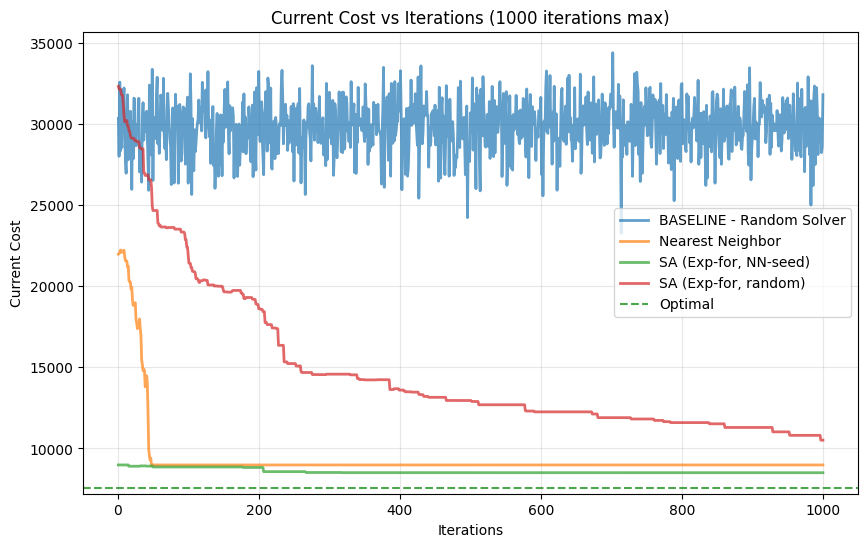

In [10]:
# Plot: Current Cost vs Iterations
plt.figure(figsize=(10, 6))
for name, data in iteration_results.items():
    plt.plot(data['iterations'], data['current_costs'], label=name, linewidth=2, alpha=0.7)
if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')
plt.xlabel('Iterations')
plt.ylabel('Current Cost')
plt.title(f'Current Cost vs Iterations ({MAX_ITERATIONS} iterations max)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


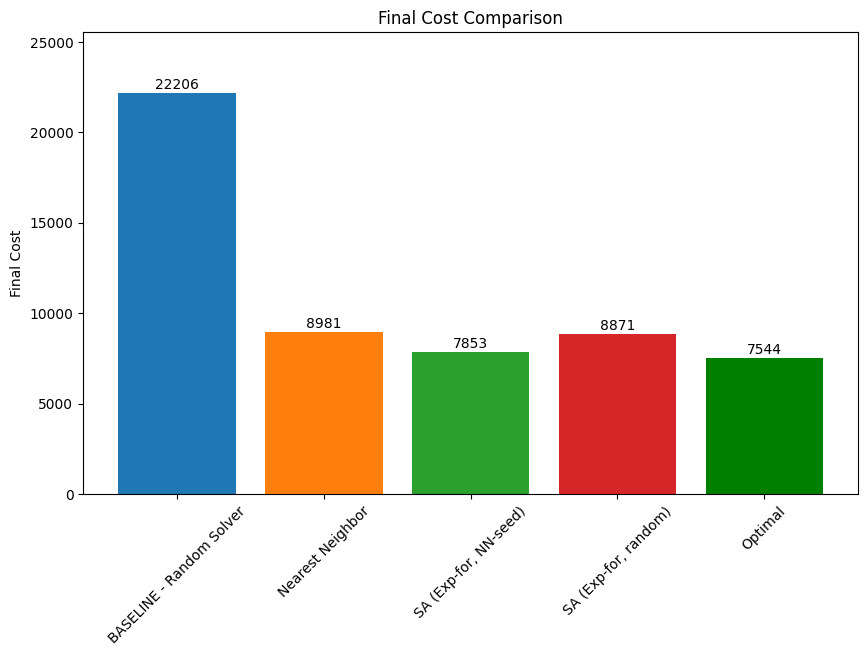

In [11]:
# Plot: Final Cost Comparison
plt.figure(figsize=(10, 6))
names = list(time_results.keys())
final_costs = [time_results[name]['final_cost'] for name in names]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(names)]
if optimal_cost is not None:
    names.append('Optimal')
    final_costs.append(optimal_cost)
    colors.append('green')

bars = plt.bar(names, final_costs, color=colors)
plt.ylabel('Final Cost')
plt.title('Final Cost Comparison')
plt.xticks(rotation=45)

for bar, cost in zip(bars, final_costs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{cost:.0f}', ha='center', va='bottom')

y_max = max(final_costs)
plt.ylim(0, y_max * 1.15)
plt.show()


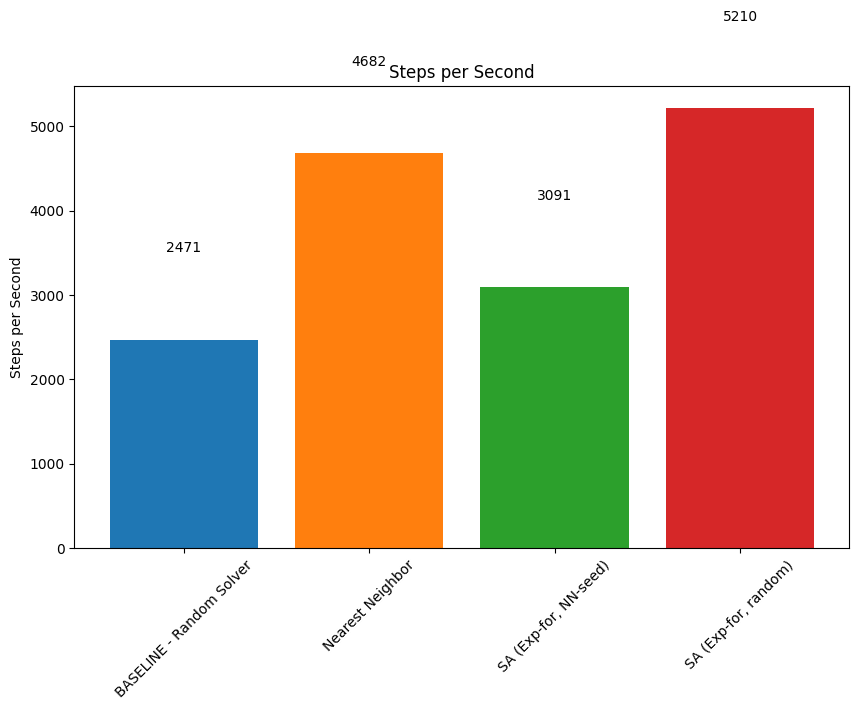

In [12]:
# Plot: Steps per Second
plt.figure(figsize=(10, 6))
algorithm_names = list(time_results.keys())
steps_per_second = [time_results[name]['total_iterations'] / MAX_SECONDS for name in algorithm_names]

bars = plt.bar(algorithm_names, steps_per_second, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(algorithm_names)])
plt.ylabel('Steps per Second')
plt.title('Steps per Second')
plt.xticks(rotation=45)

for bar, rate in zip(bars, steps_per_second):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
            f'{rate:.0f}', ha='center', va='bottom')
plt.show()


In [13]:
# Summary Statistics
print(f"Final costs near iteration {MAX_ITERATIONS}:")
for name, data in iteration_results.items():
    iterations = data['iterations']
    best_costs = data['best_costs']
    if not iterations:
        continue
    closest_idx = min(range(len(iterations)), key=lambda i: abs(iterations[i] - 50000))
    final_cost = best_costs[closest_idx]
    final_iter = iterations[closest_idx]
    print(f"{name}: {final_cost:.2f} (at iteration {final_iter})")


Final costs near iteration 1000:
BASELINE - Random Solver: 22205.62 (at iteration 1000)
Nearest Neighbor: 8980.92 (at iteration 1000)
SA (Exp-for, NN-seed): 8501.11 (at iteration 1000)
SA (Exp-for, random): 10510.11 (at iteration 1000)


## Try With a Larger Number of Iterations

In [14]:
MAX_ITERATIONS = 50_000 # INCREASED!
# Run algorithms for iteration-based benchmark
iteration_results = {}
for name, (solver, init_route) in algorithms.items():
    print(f"Running {name} for {MAX_ITERATIONS} iterations...")
    iterations, best_costs, current_costs, times = run_algorithm_with_iterations(instance, solver, init_route, MAX_ITERATIONS)
    iteration_results[name] = {
        'iterations': iterations,
        'best_costs': best_costs,
        'current_costs': current_costs,
        'times': times,
        'final_cost': best_costs[-1] if best_costs else float('inf'),
        'total_time': times[-1] if times else 0
    }
    print(f"  Final cost: {iteration_results[name]['final_cost']:.2f}")
    print(f"  Total time: {iteration_results[name]['total_time']:.3f} seconds")


Running BASELINE - Random Solver for 50000 iterations...
  Final cost: 22205.62
  Total time: 5.210 seconds
Running Nearest Neighbor for 50000 iterations...
  Final cost: 8980.92
  Total time: 6.355 seconds
Running SA (Exp-for, NN-seed) for 50000 iterations...
  Final cost: 8238.67
  Total time: 10.973 seconds
Running SA (Exp-for, random) for 50000 iterations...
  Final cost: 8102.98
  Total time: 4.663 seconds


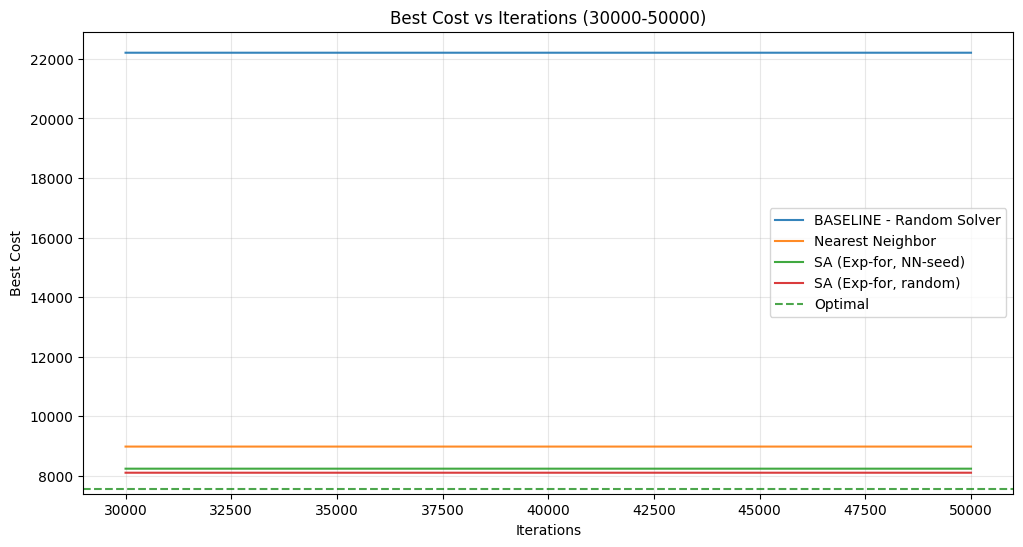

In [15]:
# Plot: Detailed Best Cost (30000-50000 iterations)
plt.figure(figsize=(12, 6))
for name, data in iteration_results.items():
    iterations = data['iterations']
    best_costs = data['best_costs']

    filtered_iterations = []
    filtered_costs = []
    for iter_num, cost in zip(iterations, best_costs):
        if 30000 <= iter_num <= 50000:
            filtered_iterations.append(iter_num)
            filtered_costs.append(cost)

    if filtered_iterations:
        plt.plot(filtered_iterations, filtered_costs, label=name, linewidth=1.5, alpha=0.9)

if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')

plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title('Best Cost vs Iterations (30000-50000)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


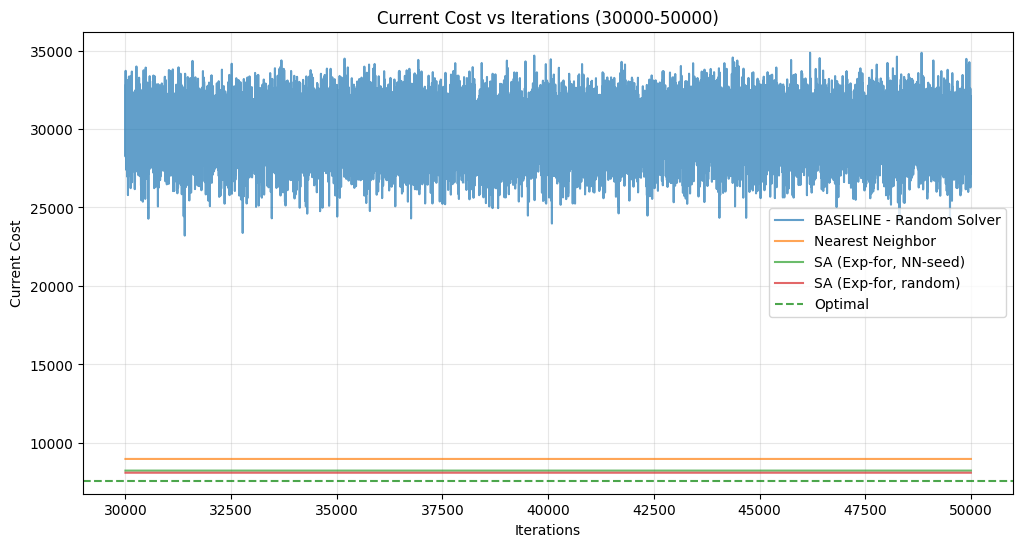

In [16]:
# Plot: Detailed Current Cost (30000-50000 iterations)
plt.figure(figsize=(12, 6))
for name, data in iteration_results.items():
    iterations = data['iterations']
    current_costs = data['current_costs']

    filtered_iterations = []
    filtered_costs = []
    for iter_num, cost in zip(iterations, current_costs):
        if 30000 <= iter_num <= 50000:
            filtered_iterations.append(iter_num)
            filtered_costs.append(cost)

    if filtered_iterations:
        plt.plot(filtered_iterations, filtered_costs, label=name, linewidth=1.5, alpha=0.7)

if optimal_cost is not None:
    plt.axhline(y=optimal_cost, color='green', linestyle='--', alpha=0.7, label='Optimal')

plt.xlabel('Iterations')
plt.ylabel('Current Cost')
plt.title('Current Cost vs Iterations (30000-50000)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [17]:
# Summary Statistics
print(f"Final costs near iteration {MAX_ITERATIONS}:")
for name, data in iteration_results.items():
    iterations = data['iterations']
    best_costs = data['best_costs']
    if not iterations:
        continue
    closest_idx = min(range(len(iterations)), key=lambda i: abs(iterations[i] - 50000))
    final_cost = best_costs[closest_idx]
    final_iter = iterations[closest_idx]
    print(f"{name}: {final_cost:.2f} (at iteration {final_iter})")


Final costs near iteration 50000:
BASELINE - Random Solver: 22205.62 (at iteration 50000)
Nearest Neighbor: 8980.92 (at iteration 50000)
SA (Exp-for, NN-seed): 8238.67 (at iteration 50000)
SA (Exp-for, random): 8102.98 (at iteration 50000)
